In [1]:
import mne
import re
import os

import numpy as np
import pandas as pd

from crosspy.core.methods import cplv, cplv_pairwise
from crosspy.preprocessing.seeg.support import clean_montage, drop_monopolar_channels
from crosspy.preprocessing.seeg.seeg_utils import create_reference_mask, get_electrode_distance
from crosspy.preprocessing.signal import preprocess_data_morlet

from bids import BIDSLayout

from joblib import Parallel, delayed

import pickle

import tqdm
import glob

import cupy as cp
import matplotlib.pyplot as plt

import scipy as sp
import scipy.signal
import scipy.io

from collections import defaultdict

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)

In [3]:
df = pd.read_csv('../seeg_phases/data/SEEG_redux_BIDS/convert_results.csv')
df_num_idx = df.set_index('subject_number')

header=['subject', 'contact', 'EZ', 'GMPI']
ez_data = pd.read_csv('202001_SEEG_ripple_Cohort_Contacts.csv', sep=';', header=None)
ez_grouped = ez_data.groupby(0)

res_files = glob.glob('derivatives/pac_no_ez/pac_sub*.pickle')

subject_to_cluster = pd.read_csv('Subject_agg_cluster_labels.csv').set_index('subject_number')

In [4]:
len(res_files)

67

In [5]:
data_normalized = defaultdict(list)
data_k = defaultdict(list)
data_raw = defaultdict(list)

data_normalized_pop = defaultdict(list)

for fname in res_files:
    subj_num = re.findall('\d+', fname)[0]
    subj_name = df_num_idx.loc[int(subj_num)]['name']
    
    if subj_num in {'36', '57'} or subject_to_cluster.loc[int(subj_num)]['subject_cluster'] == 4:
        print('Excluding {} from analysis'.format(subj_name))
        continue
    
    subj_ez_data = ez_grouped.get_group(subj_name).set_index(1)
    
    res_data = pickle.load(open(fname, 'rb'))
    
    ez_chans = np.array([int(subj_ez_data.loc[ch_name][2] != 0) for ch_name in res_data['ch_names']])
    
#     if np.sum(ez_chans) == 0:
#         print('{} does not have any EZ chans'.format(subj_name))
#         continue
    
    ref_mask = res_data['ref_mask'].astype(bool)
    n_chans = ref_mask.shape[0]
    
    nez_nez_mask = np.zeros((n_chans, n_chans), dtype=bool)
    ez_ez_mask = np.zeros((n_chans, n_chans), dtype=bool)
    ez_nez_mask = np.zeros((n_chans, n_chans), dtype=bool)
    
    for i in range(n_chans):
        for j in range(n_chans):
            nez_nez_mask[i,j] = (ez_chans[i] == 0 and ez_chans[j] == 0) and ref_mask[i,j]
            ez_ez_mask[i,j] = (ez_chans[i] == 1 and ez_chans[j] == 1) and ref_mask[i,j]
            ez_nez_mask[i,j] = ((ez_chans[i] == 1 and ez_chans[j] == 0) or (ez_chans[i] == 0 and ez_chans[j] == 1)) and ref_mask[i,j]
    
    nez_nez_mask = np.triu(nez_nez_mask, 1)
    ez_ez_mask = np.triu(ez_ez_mask, 1)
    ez_nez_mask = np.triu(ez_nez_mask, 1)
    
    surr_avg = res_data['surrogate'][:,:,ref_mask].mean(axis=2, keepdims=True)
    
    nez_nez_surr = res_data['surrogate'][:,:,nez_nez_mask].mean(axis=2, keepdims=True)
    ez_ez_surr = res_data['surrogate'][:,:,ez_ez_mask].mean(axis=2, keepdims=True)
    ez_nez_surr = res_data['surrogate'][:,:,ez_nez_mask].mean(axis=2, keepdims=True)
    
    nez_nez_data = res_data['phase_amplitude_correlation'][:,:, nez_nez_mask]
    ez_ez_data = res_data['phase_amplitude_correlation'][:,:, ez_ez_mask]
    ez_nez_data = res_data['phase_amplitude_correlation'][:,:, ez_nez_mask]
    
    nez_nez_mean = nez_nez_data.mean(axis=2)
    ez_ez_mean = ez_ez_data.mean(axis=2)
    ez_nez_mean = ez_nez_data.mean(axis=2)
    
    nez_nez_norm = nez_nez_mean / nez_nez_surr.squeeze()
    ez_ez_norm = ez_ez_mean / ez_ez_surr.squeeze()
    ez_nez_norm = ez_nez_mean / ez_nez_surr.squeeze()
    
    nez_nez_k = (nez_nez_data >= nez_nez_surr*3.52).mean(axis=2)
    ez_ez_k = (ez_ez_data >= ez_ez_surr*3.52).mean(axis=2)
    ez_nez_k = (ez_nez_data >= ez_nez_surr*3.52).mean(axis=2)

    data_normalized['nez_nez'].append(nez_nez_norm)
    data_normalized['ez_ez'].append(ez_ez_norm)
    data_normalized['ez_nez'].append(ez_nez_norm)
  
    data_k['nez_nez'].append(nez_nez_k)
    data_k['ez_ez'].append(ez_ez_k)
    data_k['ez_nez'].append(ez_nez_k)

#     data_raw['nez_nez'].append(nez_nez_mean)
#     data_raw['ez_ez'].append(ez_ez_mean)
#     data_raw['ez_nez'].append(ez_nez_mean)
    
#     data_normalized_pop['nez_nez'].append(nez_nez_data / surr_avg)
#     data_normalized_pop['ez_ez'].append(ez_ez_data / surr_avg)
#     data_normalized_pop['ez_nez'].append(ez_nez_data / surr_avg)

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater_equal
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater_equal
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater_equal
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice.
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice.
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipy

Excluding ventrone from analysis
Excluding selvabonino from analysis
Excluding podesta from analysis
Excluding migliaccio from analysis


In [6]:
high_freqs = res_data['high_frequencies']
low_freqs = res_data['low_frequencies']

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


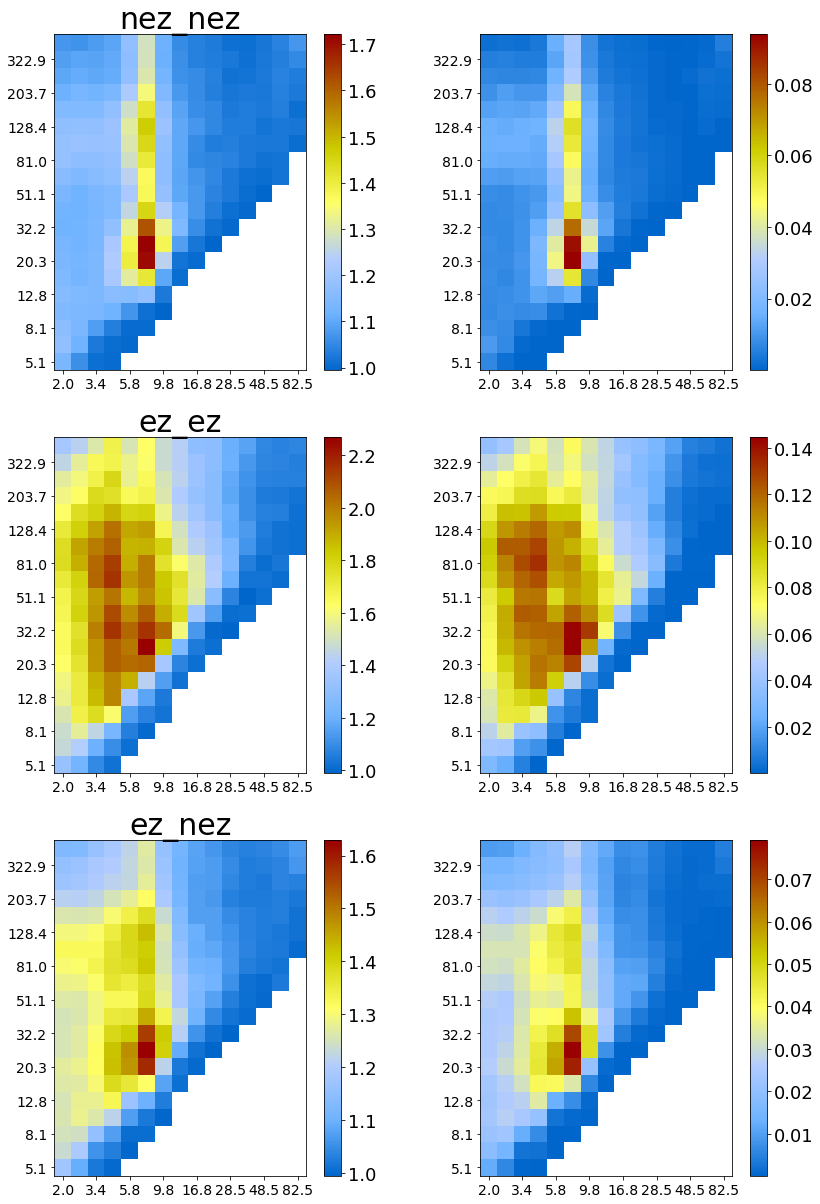

In [14]:
fig, axes = plt.subplots(figsize=(14, 21), ncols=2, nrows=3)

vmin = 10
vmax = -10
for ax, ez_type in zip(axes, data_normalized.keys()):
    ez_type_mean = np.nanmedian(data_normalized[ez_type], axis=0)
    vmin = min(vmin, np.nanmin(ez_type_mean))
    vmax = max(vmax, np.nanmax(ez_type_mean))


for ax_row, ez_type in zip(axes, data_normalized.keys()):
    ez_type_mean = np.nanmean(data_normalized[ez_type], axis=0)
    ez_type_k = np.nanmean(data_k[ez_type], axis=0)
    
    ez_type_k[np.isnan(ez_type_mean)] = np.nan
#     ez_type_mean = np.nanmean(ez_type_concat, axis=2)
#     imh = ax.imshow(ez_type_mean, origin='lower', vmin=vmin, vmax=vmax, cmap='jet')
    imh = ax_row[0].imshow(ez_type_mean, origin='lower', cmap=ripples_cmap)
    imh2 = ax_row[1].imshow(ez_type_k, origin='lower', cmap=ripples_cmap)
    
    ax_row[0].set_title(ez_type, fontsize=30)
    
    cbar = fig.colorbar(imh, ax=ax_row[0])
    cbar.ax.tick_params(labelsize=18) 
    
    cbar2 = fig.colorbar(imh2, ax=ax_row[1])
    cbar2.ax.tick_params(labelsize=18) 

for ax in axes.flatten():
    ax.set_xticks(np.arange(15)[::2])
    _ = ax.set_xticklabels(np.round(low_freqs[::2], 1))
    ax.set_yticks(np.arange(20)[::2])
    _ = ax.set_yticklabels(np.round(high_freqs[::2], 1))
    ax.tick_params(labelsize=14)

In [15]:
fig.savefig('figure_6.svg', dpi=300)
fig.savefig('figure_6.pdf', dpi=300)